In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.signal as signal
import peakutils
import wfdb
from wfdb import processing
import ecg_plot
import ast
import neurokit2 as nk

C:\Users\junho\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\junho\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\junho\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Load the raw data. The below cell has been taken from the example script in the PTB-XL dataset to load the data.

## Section 1: Loading the data and EDA

### Part 1.1: Loading the raw data

In [3]:
#Load raw_signals in array format
raw_signals = np.load('../data/created_data_files/ptb_raw_signals.npz')
raw_signals = raw_signals['arr_0']

In [4]:
raw_signals[0:1]

array([[[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
        [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
        [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
        ...,
        [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
        [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
        [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]]],
      dtype=float16)

In [5]:
#Load raw_signals that were converted to dataframe
signals_df = pd.read_csv('../data/created_data_files/ptb_signals_df.csv.gz', compression='gzip')

In [6]:
signals_df.head()

0      1      2      3      4      5      6      7      8      9  \
0 -0.119 -0.055  0.064  0.086 -0.091  0.004 -0.069 -0.031  0.000 -0.026   
1 -0.116 -0.051  0.065  0.083 -0.090  0.006 -0.064 -0.036 -0.003 -0.031   
2 -0.120 -0.044  0.076  0.082 -0.098  0.016 -0.058 -0.034 -0.010 -0.028   
3 -0.117 -0.038  0.080  0.077 -0.098  0.021 -0.050 -0.030 -0.015 -0.023   
4 -0.103 -0.031  0.072  0.066 -0.087  0.021 -0.045 -0.027 -0.020 -0.019   

      10     11  
0 -0.039 -0.079  
1 -0.034 -0.074  
2 -0.029 -0.069  
3 -0.022 -0.064  
4 -0.018 -0.058

In [7]:
signals_df.shape

(21837000, 12)

In [8]:
signals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21837000 entries, 0 to 21836999
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
dtypes: float64(12)
memory usage: 2.0 GB


In [9]:
signals_df.describe()

0             1             2             3             4  \
count  2.183700e+07  2.183700e+07  2.183700e+07  2.183700e+07  2.183700e+07   
mean  -1.845856e-03 -1.302771e-03  5.432910e-04  1.555459e-03 -1.143790e-03   
std    1.640100e-01  1.647168e-01  1.712896e-01  1.403083e-01  1.460696e-01   
min   -7.455000e+00 -5.856000e+00 -4.656000e+00 -3.679000e+00 -7.473000e+00   
25%   -6.300000e-02 -6.800000e-02 -4.000000e-02 -2.600000e-02 -4.800000e-02   
50%   -2.500000e-02 -2.200000e-02  6.000000e-03  2.400000e-02 -1.400000e-02   
75%    2.100000e-02  4.100000e-02  5.100000e-02  6.100000e-02  2.400000e-02   
max    4.398000e+00  5.576000e+00  7.491000e+00  5.920000e+00  4.425000e+00   

                  5             6             7             8             9  \
count  2.183700e+07  2.183700e+07  2.183700e+07  2.183700e+07  2.183700e+07   
mean  -3.564934e-04  1.703134e-04 -9.131268e-04 -1.488353e-03 -1.746866e-03   
std    1.465611e-01  2.337413e-01  3.376723e-01  3.336281e-01  3.058301e-01   
min   -5.300000e+00 -1.782500e+01 -1.110200e+01 -1.632000e+01 -1.119800e+01   
25%   -4.800000e-02 -2.400000e-02 -6.500000e-02 -8.700000e-02 -9.500000e-02   
50%   -6.000000e-03  2.100000e-02  0.000000e+00 -1.900000e-02 -3.300000e-02   
75%    4.000000e-02  6.500000e-02  8.900000e-02  7.800000e-02  5.000000e-02   
max    5.553000e+00  1.054700e+01  1.215700e+01  8.505000e+00  8.696000e+00   

                 10            11  
count  2.183700e+07  2.183700e+07  
mean  -7.707096e-04 -2.074064e-03  
std    2.731171e-01  2.755435e-01  
min   -1.305500e+01 -2.003200e+01  
25%   -9.000000e-02 -7.900000e-02  
50%   -3.700000e-02 -3.200000e-02  
75%    3.200000e-02  2.800000e-02  
max    1.721200e+01  1.296600e+01

In [10]:
#Set path and sampling rate
path = '../data/ptb_xl/'
sampling_rate=100

# load and convert annotation data
meta_data_df = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
meta_data_df.scp_codes = meta_data_df.scp_codes.apply(lambda x: ast.literal_eval(x))

In [11]:
# Load scp_statements.csv for diagnostic aggregation, i.e. reduce diagnostic classes to 6 superclasses
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
meta_data_df['diagnostic_superclass'] = meta_data_df.scp_codes.apply(aggregate_diagnostic)

Let's check the meta_data_df's diagnostic superclass

In [12]:
meta_data_df['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21837, dtype: object

It seems to be a list

In [13]:
#Convert the list to a string. While running this, I ran into errors. There seems to have been empty strings
#With no diagnoses. So convert empty lists to 'NO_DIAG', for no diagnosis
for i in range(1,len(meta_data_df['diagnostic_superclass'])+1):
    try:
        meta_data_df['diagnostic_superclass'][i] = meta_data_df['diagnostic_superclass'][i][0]
    except:
        meta_data_df['diagnostic_superclass'][i] = 'NO_DIAG'

<ipython-input-13-ad8a7d45a2ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data_df['diagnostic_superclass'][i] = meta_data_df['diagnostic_superclass'][i][0]
<ipython-input-13-ad8a7d45a2ad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data_df['diagnostic_superclass'][i] = 'NO_DIAG'


In [14]:
meta_data_df['diagnostic_superclass']

ecg_id
1        NORM
2        NORM
3        NORM
4        NORM
5        NORM
         ... 
21833    STTC
21834    NORM
21835    STTC
21836    NORM
21837    NORM
Name: diagnostic_superclass, Length: 21837, dtype: object

How do our raw signals look like?

In [15]:
raw_signals.shape

(21837, 1000, 12)

There are 21837 rows of data...

...Each of 10 seconds (represented by 1000)...

...measuring the 12 leads of the 12-lead ecg (i.e. 12 variables)

Let's take a look at the data

In [16]:
raw_signals[21836][999]

array([ 0.166, -0.007, -0.173, -0.08 ,  0.17 , -0.09 ,  0.069,  0.291,
        0.178,  0.106,  0.047, -0.103], dtype=float16)

raw_signals [21836] [999] refers to ecg number 21836 (the last one), on the 999th time period (10th second). The 12 float64s refers to the values of each lead of the 12-lead ecg.

Let's take a look at how one of these ecg plots look like

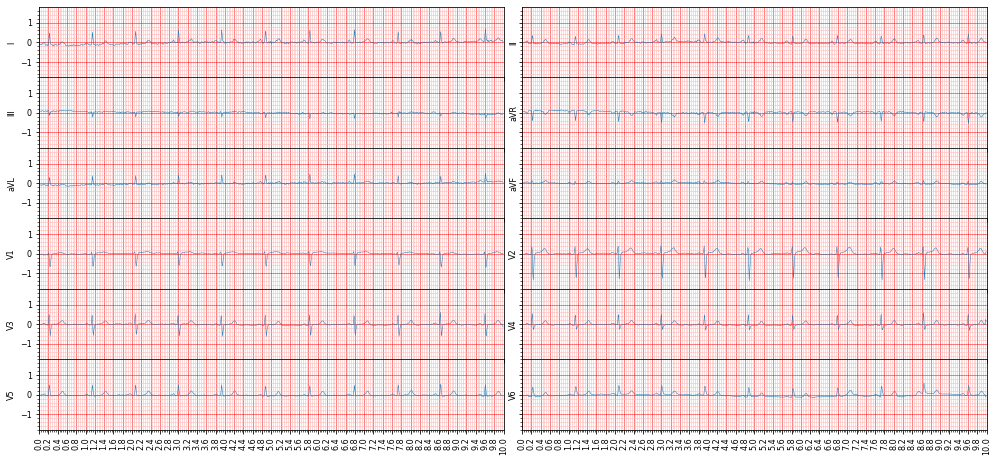

In [17]:
ecg_plot.plot_12(raw_signals[0].T, sample_rate=100, title='')
ecg_plot.show()

Saving this plot as a png

In [18]:
ecg_plot.save_as_png('example_ecg', '../data/data_images/')

### Part 1.2.1: Exploring the meta-data

Let's explore the classes and establish a baseline of model accuracy if we just guess the majority class

In [19]:
#Doing a count
meta_data_df['diagnostic_superclass'].value_counts()

NORM       9085
STTC       5250
CD         3838
MI         2721
HYP         536
NO_DIAG     407
Name: diagnostic_superclass, dtype: int64

In [20]:
#Get the mean of the value counts
meta_data_df['diagnostic_superclass'].value_counts().mean()

3639.5

In [21]:
#Get the percentage of the value counts
meta_data_df['diagnostic_superclass'].value_counts(normalize=True)*100

NORM       41.603700
STTC       24.041764
CD         17.575674
MI         12.460503
HYP         2.454550
NO_DIAG     1.863809
Name: diagnostic_superclass, dtype: float64

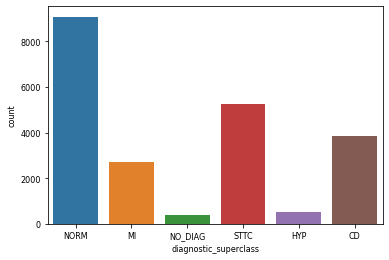

In [22]:
#Plotting the counts
sns.countplot(x = meta_data_df['diagnostic_superclass']);

It seems there is twice as many NORM heartbeats as the second most frequent class, STTC. MI follows closely behind, and there are even fewer NO_DIAG, HYP, and CD.

Put another way, there are 3 classes that are higher than the mean and 3 others that are way below the mean. NORM has about 2.5 times as many counts as the mean, while STTC and MI are about 1.4x as much. All this shows there's a severe imbalance in classes.

If we were to predict the majority class, NORM, we would be right 43.63% of the time.

In [23]:
meta_data_df.describe()

patient_id           age           sex       height       weight  \
count  21837.000000  21748.000000  21837.000000  6983.000000  9429.000000   
mean   11255.005953     59.836307      0.478912   166.708292    70.997561   
std     6234.132489     16.953125      0.499567    10.864935    15.875146   
min      302.000000      2.000000      0.000000     6.000000     5.000000   
25%     5982.000000     50.000000      0.000000   160.000000    60.000000   
50%    11423.000000     62.000000      0.000000   166.000000    70.000000   
75%    16614.000000     72.000000      1.000000   174.000000    80.000000   
max    21797.000000     95.000000      1.000000   209.000000   250.000000   

              nurse          site  validated_by    strat_fold  
count  20328.000000  21819.000000  12426.000000  21837.000000  
mean       2.292503      1.547229      0.747948      5.505335  
std        3.254786      4.169753      1.183269      2.875306  
min        0.000000      0.000000      0.000000      1.000000  
25%        0.000000      0.000000      0.000000      3.000000  
50%        1.000000      1.000000      1.000000      6.000000  
75%        3.000000      2.000000      1.000000      8.000000  
max       11.000000     50.000000     11.000000     10.000000

### Part 1.2.2: Exploring ECG data

I'm assuming you, the reader, do not have a background in reading an ecg.

We can treat the ecg as a landscape with markers on it. The shapes and patterns of these markers give us clues on the status of the patient's heart. These markers are called the **fiducial points**. If an ecg's fiducial points are healthy, we say the ecg is a sign of **normal sinus rhythm**.

Below is an example of an ecg's fiducial points that point to normal sinus rhythym.

![](../images/ecg_fiducial_points.PNG)
<p style="text-align: center;">An ecg of one heartbeat. The fiducial points all point to normal sinus rhythm. Taken from "Time-Domain Analysis of the Electrocardiogram", 2019, by Ioanna Chouvarda et al.</p>

A heartbeat begins when the **Denoisation**...

We want to take a look at the following features, taken from "Biomedical Signal Processing And Artificial Intelligence In Healthcare", pp. 106-107, 2020, by Walid Zgallai (ed.):

- **RR features**: The distance between R peaks and represents the length of time between heartbeats
- **Higher-Order statistics (HOS) features**: Where the ecg beat is segmented into _k_ segments and HOS statistics, like kurtosis and skewness, are calculated. This results in a 2 x _k_-dimensional feature for each beat
- **Local Binary Patterns (LBP) features**: ECG is one-dimensional time-series data, so a 1-dimensional LBP can be calculated for each data point in the segmented beat.
- **Wavelet features**: Using the discrete wavelet transform, we can extract wavelet features from the segmented ecg beats. Wavelet features have both spatial and temporal information from the QRS complex. Here, the wavelet transform is "applied to each beat signal using the Daubechies 3 family and a specific decomposition level. The approximation band coefficients are then used as wavelet features for the beat".

We have to first pre-process the data. Let's try this out on one patient's full, 10-second ecg data

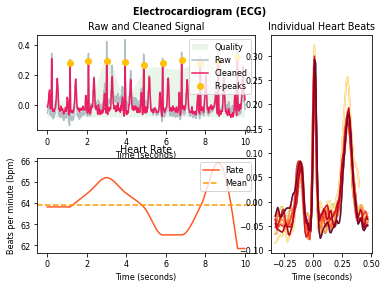

In [24]:
ecg_signals, info = nk.ecg_process(signals_df.iloc[0:1000,1], sampling_rate=100)
plot = nk.ecg_plot(ecg_signals, sampling_rate=100)

In [25]:
nk.ecg_intervalrelated(ecg_signals)


C:\Users\junho\anaconda3\lib\site-packages\neurokit2\signal\signal_psd.py:109: NeuroKitWarning: The duration of recording is too short to support a sufficiently long window for high frequency resolution. Consider using a longer recording or increasing the `min_frequency`
  warn(


ECG_Rate_Mean  HRV_RMSSD  HRV_MeanNN  HRV_SDNN  HRV_SDSD  HRV_CVNN  \
0      63.916476   2.645751        94.0       2.0   2.77746  0.021277   

   HRV_CVSD  HRV_MedianNN  HRV_MadNN  HRV_MCVNN  ...   HRV_C2d   HRV_C2a  \
0  0.028146          94.0     2.9652   0.031545  ...  0.432646  0.567354   

   HRV_SD2d  HRV_SD2a    HRV_Cd    HRV_Ca  HRV_SDNNd  HRV_SDNNa  HRV_ApEn  \
0  1.261554  1.444664  0.597965  0.402035   1.515176   1.242388  0.133531   

   HRV_SampEn  
0        -inf  

[1 rows x 53 columns]

Let's try the same process with a different lead from the same patient. We should get similar results since they are from the same ecg. Differences in values should be because of differences in measurement from the electrode placement and cleaning.

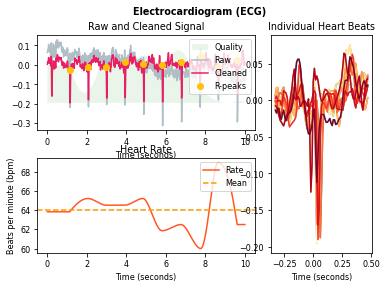

In [26]:
ecg_signals_2, info = nk.ecg_process(signals_df.iloc[0:1000,2], sampling_rate=100)
plot = nk.ecg_plot(ecg_signals_2, sampling_rate=100)

In [27]:
nk.ecg_intervalrelated(ecg_signals_2)


C:\Users\junho\anaconda3\lib\site-packages\neurokit2\signal\signal_psd.py:109: NeuroKitWarning: The duration of recording is too short to support a sufficiently long window for high frequency resolution. Consider using a longer recording or increasing the `min_frequency`
  warn(


ECG_Rate_Mean  HRV_RMSSD  HRV_MeanNN  HRV_SDNN  HRV_SDSD  HRV_CVNN  \
0      64.004652   6.062178        94.0  3.741657   6.45866  0.039805   

   HRV_CVSD  HRV_MedianNN  HRV_MadNN  HRV_MCVNN  ...   HRV_C2d   HRV_C2a  \
0  0.064491          93.0     4.4478   0.047826  ...  0.731884  0.268116   

   HRV_SD2d  HRV_SD2a    HRV_Cd    HRV_Ca  HRV_SDNNd  HRV_SDNNa  HRV_ApEn  \
0  2.685942  1.625687  0.518519  0.481481   2.828427   2.725541  0.133531   

   HRV_SampEn  
0        -inf  

[1 rows x 53 columns]

Let's detect the R_peaks from the first patient. R_peaks are best detected from lead 2, which is column 1 in the dataframe.

In [28]:
_, r_peaks = nk.ecg_peaks(ecg_signals, sampling_rate=100)

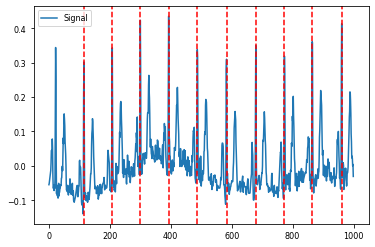

In [29]:
plot = nk.events_plot(r_peaks['ECG_R_Peaks'], signals_df.iloc[0:1000,1])

0. ecg_clean
1. ecg_findpeaks
2. hrv_time

Let's clean the ecgs with nk.ecg_clean in preparation to find peaks and get the heart rate variability

In [114]:
#Define a function for nk functions that output a dataframe
def nk_func_on_ecg(dataframe, function_name):
    """
    Input: 
    
    1. A dataframe with 21837000 rows and 12 columns, with each row being a time step and each column being a lead
    of the ecg reading.
    
    2. A string with the name of the neurokit function used, without the 'nk' prefix. e.g. use 'ecg_clean' to use
    nk.ecg_clean on the dataframe.
    
    Output: A dataframe with 21837000 rows and 12 columns, with each row being one ecg value at a time step, and a
    column being one ecg lead.
    """
    
    #Initialise the empty output_df
    output_df = pd.DataFrame(data=None)
    
    for i in range(12):
        array = getattr(nk, function_name)(dataframe.iloc[:,i], sampling_rate=100)
        
        #Turn the above output_array into a dataframe for concatenation
        df_for_appending = pd.DataFrame(array)
        
        #Concatenate df_for_appending to the output_df
        output_df = pd.concat([output_df, df_for_appending], axis=1)
        
    #Rename columns with lead number
    output_df.columns = [0,1,2,3,4,5,6,7,8,9,10,11]
    
    return output_df

In [125]:
cleaned_signals_df = nk_func_on_ecg(signals_df, 'ecg_clean')

In [129]:
#Define a function for nk functions that output a dataframe of 1s and 0s and a dictionary of samples
def nk_df_and_samples(dataframe, function_name):
    """
    Input: 
    
    1. A dataframe with 21837000 rows and 12 columns, with each row being a time step and each column being a lead
    of the ecg reading.
    
    2. A string with the name of the neurokit function used, without the 'nk' prefix. e.g. use 'ecg_delineate' to use
    nk.ecg_delineate on the dataframe.
    
    Output: A dataframe with 21837000 rows and 12 columns, with each row being one ecg value at a time step, and a
    column being one ecg lead.
    """
    
    #Initialise the empty output_df
    output_df = pd.DataFrame(data=None)
    
    for i in range(12):
        df_and_dict = getattr(nk, function_name)(dataframe.iloc[:,i], sampling_rate=100)
        
        #Turn the above output_array into a dataframe for concatenation
        df_for_appending = pd.DataFrame(df_and_dict[0])
        
        #Concatenate df_for_appending to the output_df
        output_df = pd.concat([output_df, df_for_appending], axis=1)
        
    #Rename columns with lead number
    output_df.columns = [f'{function_name}_0,{function_name}_1,{function_name}_2,{function_name}_3,\
                        {function_name}_4,{function_name}_5, {function_name}_6,{function_name}_7,\
                        {function_name}_8,{function_name}_9,{function_name}_10,{function_name}_11']
    
    return output_df

In [137]:
#Define a function for heart rate variability that output a dataframe
def hrv(dataframe):
    """
    Input: A dataframe with 21837000 rows and 12 columns, with each row being a time step and each column being a lead
    of the ecg reading.
    Output: A dataframe with 11 rows and 14 columns, with each row being summary values of heart rate variability, 
    and a column being a statistic for heart rate variability.
    """
    
    #Initialise the empty output_df
    output_df = pd.DataFrame(data=None)
    
    for i in range(12):
        channel_summary = nk.hrv_time(dataframe.iloc[:,i], sampling_rate=100)
        
        #Concatenate the channel heart rate variability to the output_df, concatenated on the row axis
        output_df = pd.concat([output_df, channel_summary], axis=0)
    
    output_df.index = [0,1,2,3,4,5,6,7,8,9,10,11,]
    
    return output_df

Find the R-peaks for the cleaned signals

In [138]:
# Doesn't work
# nk_df_and_samples(cleaned_signals_df, 'ecg_peaks')

Let's find the QRS complex

Let's get the heart rate variability information

In [139]:
hrv(cleaned_signals_df)

HRV_RMSSD    HRV_MeanNN  HRV_SDNN  HRV_SDSD      HRV_CVNN      HRV_CVSD  \
0    0.611698 -3.090121e-08  0.680571  0.611698 -2.202410e+07 -1.979528e+07   
1    0.616956 -3.367274e-08  0.684130  0.616956 -2.031703e+07 -1.832211e+07   
2    0.510828 -2.666629e-09  0.596276  0.510828 -2.236066e+08 -1.915633e+08   
3    0.558773  3.227895e-08  0.613830  0.558773  1.901641e+07  1.731076e+07   
4    0.471564 -1.403423e-08  0.540624  0.471564 -3.852182e+07 -3.360099e+07   
5    0.476772 -1.815449e-08  0.543939  0.476772 -2.996170e+07 -2.626191e+07   
6    0.679437  4.126442e-08  0.834104  0.679437  2.021363e+07  1.646545e+07   
7    1.086779 -3.280476e-09  1.284573  1.086779 -3.915814e+08 -3.312872e+08   
8    1.188415 -3.594655e-08  1.323079  1.188415 -3.680683e+07 -3.306062e+07   
9    1.315198 -5.815146e-08  1.374903  1.315198 -2.364348e+07 -2.261677e+07   
10   1.150680 -6.010425e-08  1.218012  1.150680 -2.026499e+07 -1.914474e+07   
11   0.843802 -4.553819e-08  0.927357  0.843802 -2.036439e+07 -1.852956e+07   

    HRV_MedianNN  HRV_MadNN    HRV_MCVNN  HRV_IQRNN  HRV_pNN50  HRV_pNN20  \
0       0.005921   0.127519    21.537962   0.172022   0.000000   0.000027   
1       0.007266   0.122952    16.921242   0.165860   0.000000   0.000027   
2       0.000040   0.093923  2344.734538   0.126714   0.000000   0.000009   
3      -0.007241   0.116332   -16.065951   0.156967   0.000000   0.000005   
4       0.002119   0.092741    43.771355   0.125092   0.000000   0.000009   
5       0.003715   0.092879    24.999155   0.125290   0.000000   0.000009   
6       0.001683   0.081822    48.629784   0.111082   0.000000   0.000110   
7       0.006296   0.120380    19.120894   0.171492   0.000000   0.000627   
8       0.008227   0.131415    15.972918   0.187660   0.000000   0.001145   
9       0.009332   0.115995    12.429773   0.161278   0.000000   0.003961   
10      0.006925   0.097054    14.015608   0.131561   0.000000   0.001626   
11      0.003943   0.085233    21.617982   0.114876   0.000018   0.000160   

      HRV_TINN     HRV_HTI  
0    67.006111  179.854211  
1    48.292606  124.502543  
2    59.617473  132.732383  
3    49.279873  188.146187  
4    60.226112  196.549108  
5    50.545006  189.294374  
6   125.986699  100.002743  
7    86.919535   97.103391  
8   114.535997  100.227650  
9    94.783254  105.953930  
10   81.137908  111.756512  
11  130.819743  111.590895

The meaning of the heart rate variability summary is described below, taken from the [Neurokit2 documentation](https://neurokit2.readthedocs.io/en/latest/functions.html?highlight=heartbeat#module-neurokit2.hrv). The specific function used is 'hrv_time'.

1. RMSSD: The square root of the mean of the sum of successive differences between adjacent RR intervals. It is equivalent (although on another scale) to SD1, and therefore it is redundant to report correlations with both (Ciccone, 2017).


2. MeanNN: The mean of the RR intervals.


3. SDNN: The standard deviation of the RR intervals.


4. SDSD: The standard deviation of the successive differences between RR intervals.


5. CVNN: The standard deviation of the RR intervals (SDNN) divided by the mean of the RR intervals (MeanNN).


6. CVSD: The root mean square of the sum of successive differences (RMSSD) divided by the mean of the RR intervals (MeanNN).


7. MedianNN: The median of the absolute values of the successive differences between RR intervals.


8. MadNN: The median absolute deviation of the RR intervals.


9. HCVNN (Perhaps this is what MCVNN is supposed to be?): The median absolute deviation of the RR intervals (MadNN) divided by the median of the absolute differences of their successive differences (MedianNN).


10. IQRNN: The interquartile range (IQR) of the RR intervals.


11. pNN50: The proportion of RR intervals greater than 50ms, out of the total number of RR intervals.


12. pNN20: The proportion of RR intervals greater than 20ms, out of the total number of RR intervals.


13. TINN: A geometrical parameter of the HRV, or more specifically, the baseline width of the RR intervals distribution obtained by triangular interpolation, where the error of least squares determines the triangle. It is an approximation of the RR interval distribution.


14. HTI: The HRV triangular index, measuring the total number of RR intervals divded by the height of the RR intervals histogram.

# ECG Analysis here

In [144]:
created_epochs = nk.epochs_create(cleaned_signals_df)

In [161]:
epoch_df =nk.epochs_to_df(created_epochs)

In [165]:
analyzed_epochs = nk.ecg_eventrelated(epoch_df)

KeyboardInterrupt: 